In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time,datetime

today = datetime.date.today()

from datetime import date,timedelta
import jpholiday

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from pycaret.regression import *

import os, shutil, requests,zipfile

# 厚生労働省のHPからCSVをDL
https://www.mhlw.go.jp/stf/covid-19/open-data.html

# Google モビリティからZIPをDL
https://www.google.com/covid19/mobility/

# 気象庁から手作業で気温・湿度DL
https://www.data.jma.go.jp/gmd/risk/obsdl/index.php

In [2]:
''' 厚生労働省データ '''
positive = 'https://www.mhlw.go.jp/content/pcr_positive_daily.csv'
pcr_test = 'https://www.mhlw.go.jp/content/pcr_tested_daily.csv'

''' Google data '''
url = 'https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip'
file_name = os.path.basename(url)
res = requests.get(url, stream=True)
if res.status_code == 200:
    with open('./zip/'+file_name, 'wb') as file:
        res.raw.decode_content = True
        shutil.copyfileobj(res.raw, file)
        
with zipfile.ZipFile('./zip/'+file_name) as existing_zip:
    #print(existing_zip.namelist())
    existing_zip.extract('2020_JP_Region_Mobility_Report.csv','./csv/')


temp = pd.read_csv('./csv/data.csv',encoding="shift-jis",header=2) #https://www.data.jma.go.jp/gmd/risk/obsdl/index.php
temp = temp.iloc[1:,[0,1,4]] #余計な行列を削除

pos = pd.read_csv(positive)
pcr = pd.read_csv(pcr_test)

mb = pd.read_csv('./csv/2020_JP_Region_Mobility_Report.csv')
mb = mb[mb['sub_region_1']=='Tokyo']
mb = mb.iloc[:,[7,8,11]]

pos.columns = ['Date','Positive']
pcr.columns = ['Date','Test']
mb.columns = ['Date','RecRate','TrainRate']
temp.columns = ['Date','Humidity','Temparature']

pos['Date'] = pd.to_datetime(pos['Date'])
pcr['Date'] = pd.to_datetime(pcr['Date'])
mb['Date'] = pd.to_datetime(mb['Date'])
temp['Date'] = pd.to_datetime(temp['Date'])

pos = pos.set_index('Date')
pcr = pcr.set_index('Date')
mb = mb.set_index('Date')
temp = temp.set_index('Date')

df = pd.concat([pos,pcr],axis=1)
df = pd.concat([df,mb],axis=1)
df = pd.concat([df,temp],axis=1)

# 乗車率の欠損値補完
# 祝日・曜日フラグ

In [3]:
df

,Positive,Test,RecRate,TrainRate,Humidity,Temparature
Date,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,49.0,5.5
2020-01-02,NaN,NaN,NaN,NaN,60.0,6.2
2020-01-03,NaN,NaN,NaN,NaN,63.0,6.1
2020-01-04,NaN,NaN,NaN,NaN,53.0,7.2
2020-01-05,NaN,NaN,NaN,NaN,61.0,5.4
2020-01-06,NaN,NaN,NaN,NaN,44.0,7.5
2020-01-07,NaN,NaN,NaN,NaN,71.0,5.7
2020-01-08,NaN,NaN,NaN,NaN,97.0,5.2
2020-01-09,NaN,NaN,NaN,NaN,47.0,10.6


In [4]:
df2 = df.copy()
df2=df2.interpolate()
df2.fillna(0,inplace=True)

df2['is_holiday'] = df2.index.map(jpholiday.is_holiday).astype(int)
df2['dayofweek'] = df2.index.dayofweek


# 30日前のラグ特徴量作成

In [5]:
df3 = df2.copy()
df3['Date'] = df3.index + timedelta(days=30)
df3 = df3.set_index('Date')
df3.columns = ['Positive_lag30','Test_lag30','RecRate_lag30','TrainRate_lag30',
               'Humidity_lag30','Temparature_lag30','is_holiday_lag30','dayofweek_lag30']

df3['Positive']= df2['Positive']
df3 =df3.fillna(0)

# StandardScalerでグラフ描画

In [6]:
scaler = StandardScaler()
df4 = scaler.fit_transform(df2)
df4 = pd.DataFrame(df4)
df4.columns = df2.columns
df4.index = df2.index

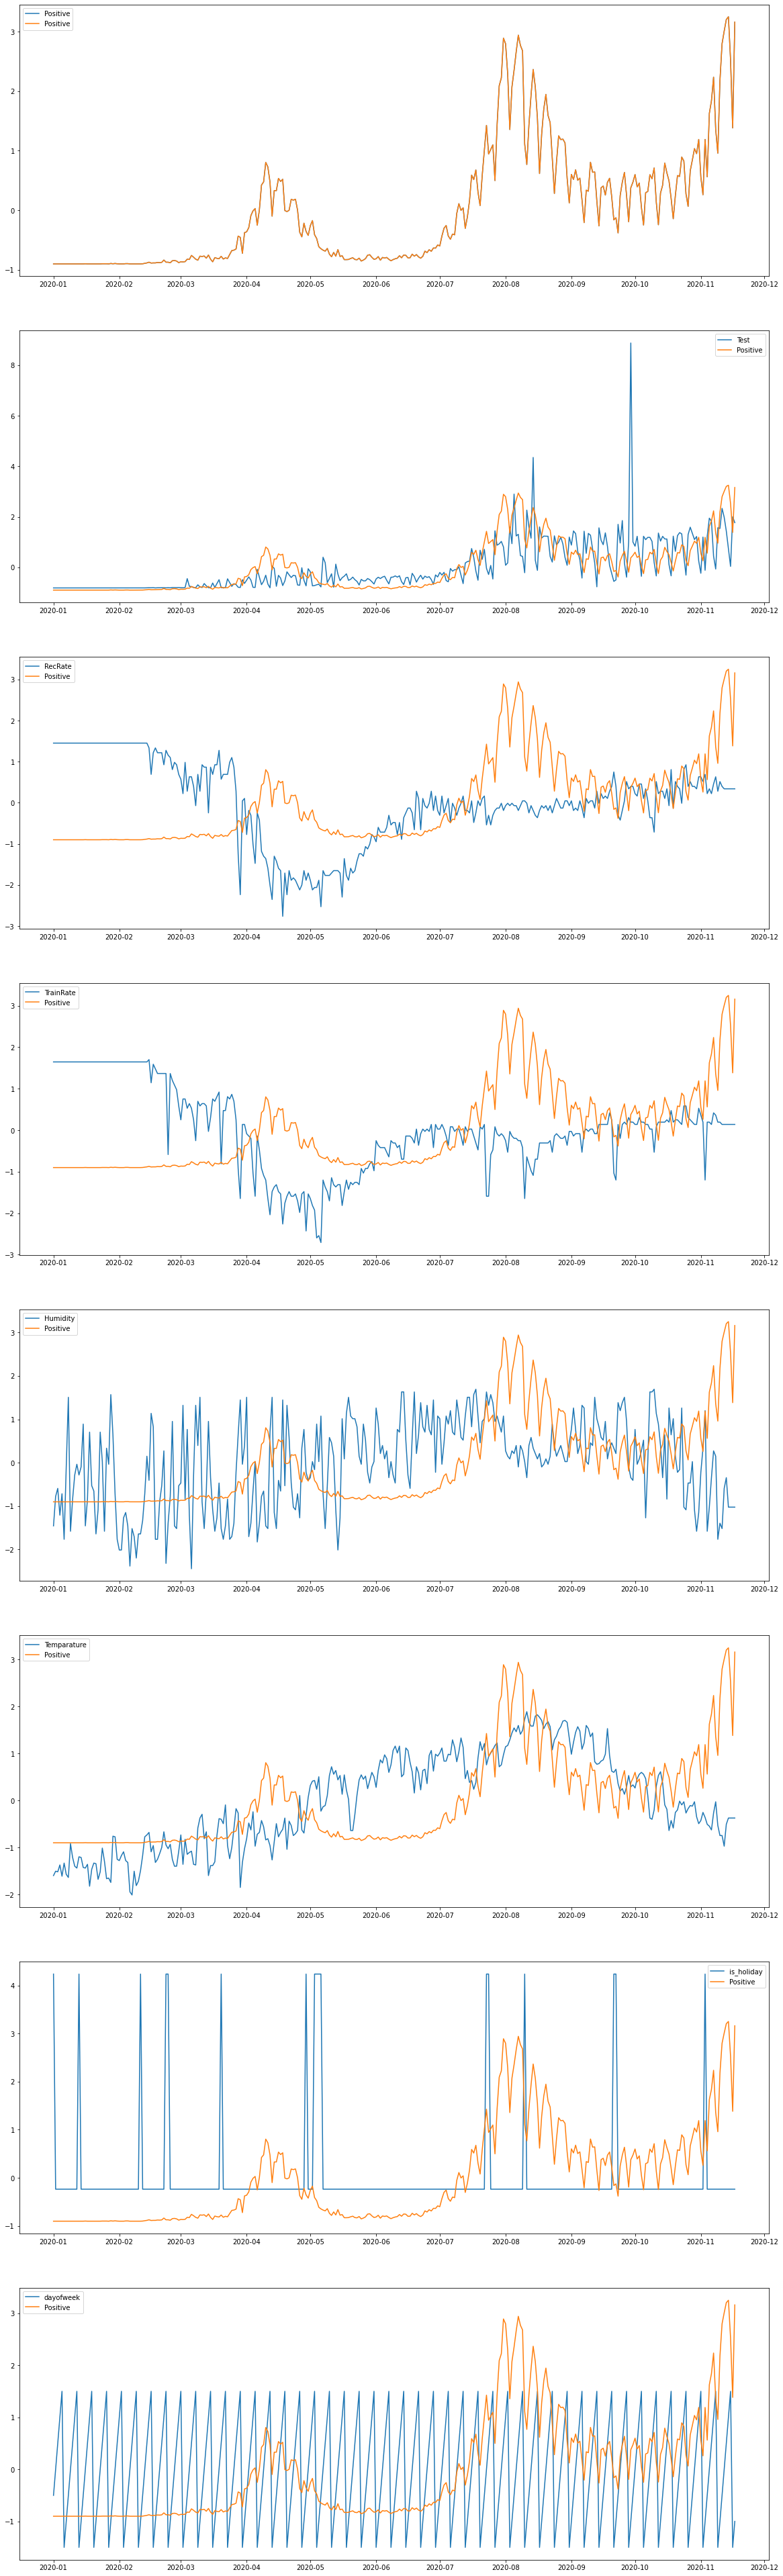

In [7]:
plt.figure(figsize=(20,70))
for ncol,colname in enumerate(df4.columns):
    plt.subplot(len(df4.columns),1,ncol+1)
    plt.plot(df4[colname])
    plt.plot(df4['Positive'])
    plt.legend(labels=[colname,'Positive'])

# pyCaret Regression

In [8]:
X_train = df3.iloc[:-30,:-1]
y_train = df3.iloc[:-30,-1]
X_test = df3.iloc[-30:,:-1]
y_test = df3.iloc[-30:,-1]

In [9]:
exp1 = setup(df3.iloc[:-30,:],'Positive')

,Description,Value
0,session_id,7607
1,Target,Positive
2,Original Data,"(292, 9)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(204, 14)"


In [10]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,146.1849,53282.5371,221.2285,0.7053,0.7839,1.1316,0.7650
et,Extra Trees Regressor,150.6069,55489.9350,227.0060,0.6926,0.6687,0.6956,0.1520
rf,Random Forest Regressor,151.2872,57252.2751,228.8429,0.6913,0.6404,0.5979,0.1600
lightgbm,Light Gradient Boosting Machine,160.3494,58630.0911,234.2972,0.6650,0.8310,0.9628,0.0090
ada,AdaBoost Regressor,179.8266,61938.1910,243.9195,0.6385,1.2283,2.6310,0.0270
gbr,Gradient Boosting Regressor,161.6709,64374.2821,243.4460,0.6307,0.7899,0.8614,0.0150
xgboost,Extreme Gradient Boosting,159.9664,66456.3166,248.7014,0.6244,0.6736,0.6238,0.1500
en,Elastic Net,255.1846,111227.5578,326.5671,0.3661,1.5207,5.2400,0.0070
llar,Lasso Least Angle Regression,256.7761,112151.5745,327.8219,0.3629,1.5578,5.6024,0.0060
br,Bayesian Ridge,255.1774,112293.0581,328.3297,0.3607,1.5374,5.5036,0.0060


In [11]:
cat = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,90.1023,15210.9933,123.3329,0.9073,0.5821,0.5951
1,214.3986,100951.5532,317.7287,0.6767,0.7490,1.1992
2,138.8071,45055.9352,212.2638,0.6788,0.9164,0.6591
3,162.1306,64456.7328,253.8833,0.6163,1.1561,0.6487
4,186.7367,58885.8992,242.6642,0.7277,1.0423,5.2036
5,118.0045,23990.3033,154.8880,0.8289,0.7136,0.3371
6,99.8044,24001.0114,154.9226,0.7699,0.8427,0.3553
7,113.6018,27139.0376,164.7393,0.6545,0.7698,1.2128
8,156.8727,94261.8199,307.0209,0.6379,0.4554,0.5529
9,181.3903,78872.0852,280.8417,0.5551,0.6118,0.5520


In [12]:
xgb = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,93.9648,19981.5684,141.3562,0.8783,0.6314,0.4713
1,245.8535,135066.6094,367.5141,0.5674,0.7981,1.1365
2,159.3492,72722.4375,269.6710,0.4816,0.8713,0.5393
3,175.1744,94169.0859,306.8698,0.4394,0.8401,0.5105
4,186.2531,68338.5547,261.4164,0.6840,0.7459,1.4802
5,170.3402,46642.2773,215.9682,0.6673,0.6492,0.3998
6,107.5606,25510.1484,159.7190,0.7555,0.6646,0.3073
7,107.8846,34249.9297,185.0674,0.5640,0.4676,0.5100
8,165.1655,85336.1094,292.1234,0.6722,0.5814,0.4120
9,188.1178,82546.4453,287.3090,0.5344,0.4867,0.4714


In [13]:
tuned_cat = tune_model(cat)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,101.6507,23197.2863,152.3066,0.8587,0.7025,0.9348
1,223.1958,104777.5835,323.6937,0.6644,0.8039,1.5854
2,157.2002,54654.9745,233.7840,0.6104,1.0396,0.8157
3,166.0119,59758.8746,244.4563,0.6443,1.5253,0.8560
4,175.2581,53782.6669,231.9109,0.7513,1.1698,3.5607
5,158.4033,40880.9087,202.1903,0.7084,0.9032,0.4844
6,110.5412,23373.5132,152.8840,0.7760,0.3300,0.3151
7,94.6485,19039.4437,137.9835,0.7576,0.8782,1.8367
8,157.3171,83496.3931,288.9574,0.6793,0.8182,1.3432
9,160.7775,63777.3683,252.5418,0.6403,0.5506,0.4239


In [14]:
tuned_xgb = tune_model(xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,75.6159,12836.1992,113.2970,0.9218,0.6053,0.6399
1,234.6119,111792.8594,334.3544,0.6419,0.9439,1.3287
2,142.7163,50381.1719,224.4575,0.6408,0.8303,0.6745
3,177.9145,86675.8906,294.4077,0.4840,1.1843,0.6832
4,195.5462,77396.7344,278.2027,0.6421,0.8559,1.5881
5,183.3099,54528.5391,233.5135,0.6110,0.9588,0.4304
6,94.4975,18619.8242,136.4545,0.8215,0.5700,0.4578
7,121.7585,37373.5469,193.3224,0.5242,0.5916,0.7596
8,171.2878,73554.2969,271.2090,0.7175,0.5529,0.7399
9,197.8537,86987.3984,294.9362,0.5094,0.5994,0.5681


In [15]:
ensemble = blend_models([cat,xgb])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,88.5053,16269.5039,127.5520,0.9009,0.5283,0.4928
1,227.5345,115342.7991,339.6216,0.6306,0.7641,1.1565
2,135.7528,54132.2841,232.6635,0.6141,0.8644,0.5387
3,162.2413,73158.7418,270.4787,0.5645,0.9624,0.5736
4,185.2537,61054.4472,247.0920,0.7177,0.9288,3.3366
5,137.2951,30375.9929,174.2871,0.7833,0.6669,0.3435
6,99.2692,23300.0156,152.6434,0.7767,0.7726,0.3021
7,108.8926,26902.1412,164.0187,0.6575,0.6066,0.8196
8,157.1258,87719.8487,296.1754,0.6630,0.5967,0.4338
9,176.6348,75203.7081,274.2329,0.5758,0.4752,0.4599


In [16]:
stacking = stack_models(estimator_list = [cat],meta_model = xgb)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,102.6735,24355.4316,156.0623,0.8516,0.4574,0.3886
1,218.6020,113395.2656,336.7421,0.6368,0.6721,0.8725
2,142.7878,44375.9141,210.6559,0.6836,0.8698,0.5486
3,144.6366,49839.1758,223.2469,0.7033,0.9170,0.3853
4,165.9795,56986.6562,238.7188,0.7365,0.6632,0.8347
5,137.1297,33381.5430,182.7062,0.7619,0.6550,0.2631
6,103.1561,22041.5391,148.4639,0.7887,0.4609,0.3310
7,108.0350,24235.1016,155.6763,0.6915,0.5649,0.7128
8,171.0054,113789.7500,337.3274,0.5629,0.4994,0.4244
9,153.1301,45191.1094,212.5820,0.7451,0.5539,0.5315


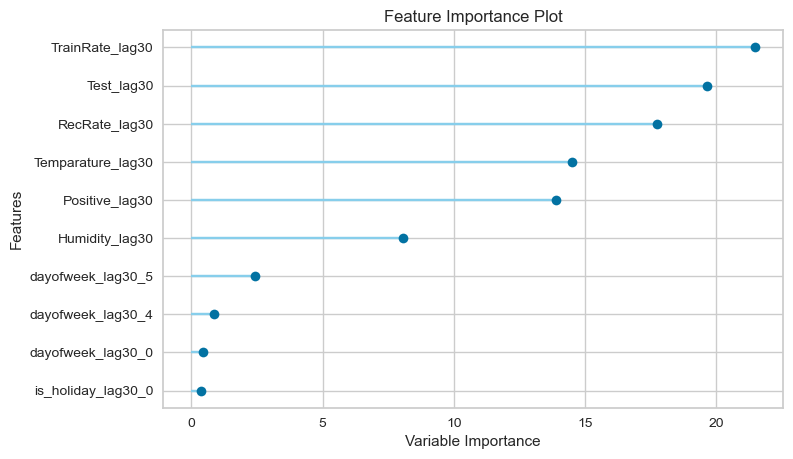

In [17]:
plot_model(cat,plot='feature')

In [18]:
#plot_model(tuned_cat)

In [19]:
#interpret_model(tuned_cat)

In [20]:
cat_predicted = predict_model(tuned_cat)
ens_predicted = predict_model(ensemble)
stack_predicted = predict_model(stacking)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,126.2970,36140.5233,190.1066,0.7598,1.0250,1.5292


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,101.9471,27905.5776,167.0496,0.8145,0.7352,1.0222


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,116.7063,32559.4375,180.4423,0.7836,0.6949,0.5903


In [21]:
cat_pred = predict_model(tuned_cat,data=df3)
ens_pred = predict_model(ensemble,data=df3)
stack_pred = predict_model(stacking,data=df3)

In [25]:
cat_pred.to_csv('./pred/cat_pred30_'+ str(today)  + '.csv')
ens_pred.to_csv('./pred/ens_pred30_'+ str(today)  + '.csv')
stack_pred.to_csv('./pred/stack_pred30_'+ str(today)  + '.csv')

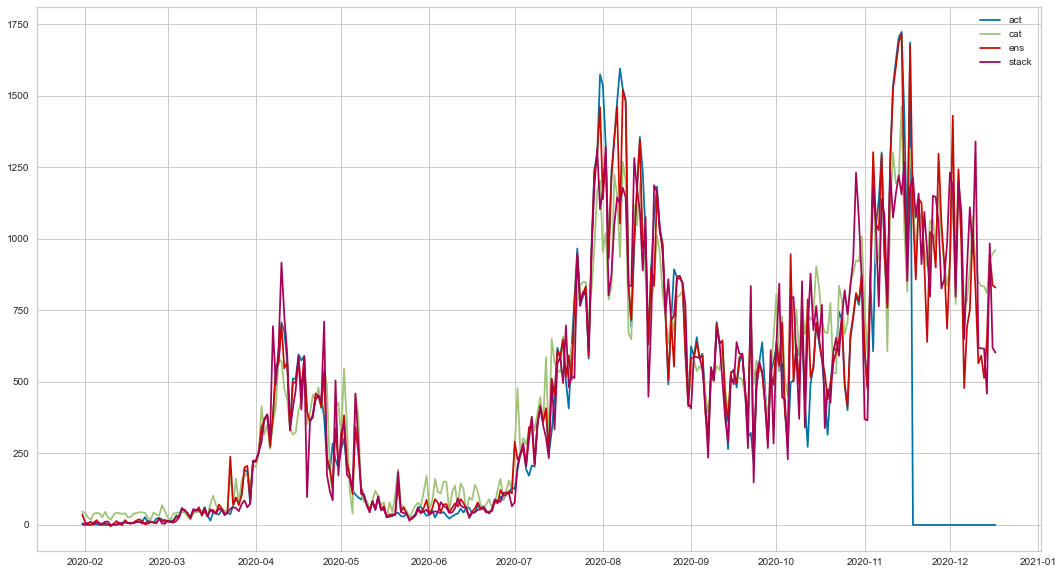

In [24]:
plt.figure(figsize=(18,10))
plt.plot(cat_pred['Positive'],label='act')
plt.plot(cat_pred['Label'],label='cat')
plt.plot(ens_pred['Label'],label ='ens')
plt.plot(stack_pred['Label'],label='stack')
plt.legend()
plt.savefig('./fig/model03_pred30dys_pycaret_'+str(today)+'.png')

# 60/45/30日で比較

In [34]:
stack_pred30 = pd.read_csv('./pred/stack_pred30_'+ str(today)  + '.csv')
stack_pred45 = pd.read_csv('./pred/stack_pred45_'+ str(today)  + '.csv')
stack_pred60 = pd.read_csv('./pred/stack_pred60_'+ str(today)  + '.csv')

stack_pred30['Date'] = pd.to_datetime(stack_pred30['Date'])
stack_pred45['Date'] = pd.to_datetime(stack_pred45['Date'])
stack_pred60['Date'] = pd.to_datetime(stack_pred60['Date'])
stack_pred30 = stack_pred30.set_index('Date')
stack_pred45 = stack_pred45.set_index('Date')
stack_pred60 = stack_pred60.set_index('Date')

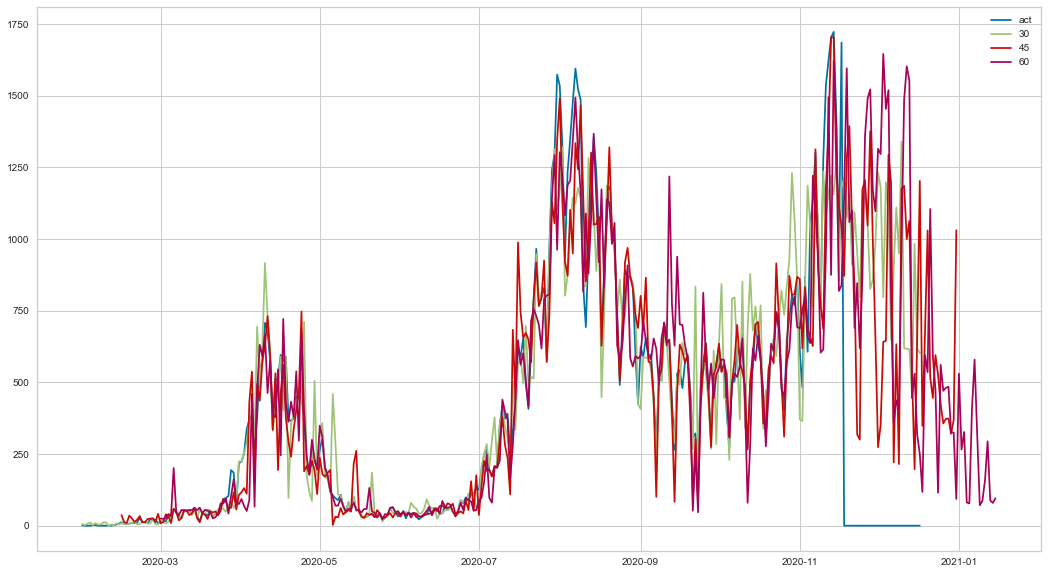

In [61]:
plt.figure(figsize=(18,10))
plt.plot(stack_pred30['Positive'],label='act')
plt.plot(stack_pred30['Label'],label='30')
plt.plot(stack_pred45['Label'],label ='45')
plt.plot(stack_pred60['Label'],label ='60')

plt.legend()
#plt.savefig('./fig/model03_compare_pycaret_'+str(today)+'.png')